In [154]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [155]:
df = pd.read_csv('https://gist.githubusercontent.com/singhsidhukuldeep/cc3c9597bce35f5f242a921eb3361c75/raw/54227431f0dc8ac1c438f438e2174d181fdda330/blinkit_multiclass.csv')
df.head()

,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,class
0,3,12669,9656,7561,214,2674,1338,2
1,3,7057,9810,9568,1762,3293,1776,2
2,3,6353,8808,7684,2405,3516,7844,2
3,3,13265,1196,4221,6404,507,1788,1
4,3,22615,5410,7198,3915,1777,5185,1


Data Description

feature	            Description

Region:	            where the store is located (1: Tier-1 city, 2: Tier-2 city, 3:Tier-3 city)

Fresh:	            purchase history of Fresh food

Milk:	            purchase history of milk product

Grocery:	        purchase history of Grocery

Frozen:	            purchase history of Frozen food

Detergents_Paper:	purchase history of washing products

Delicassen:	        purchase history of imported products, cooked meat

class:	            Store catgeory based on demand on products	

### Let us see the count of sample each of the three classes 

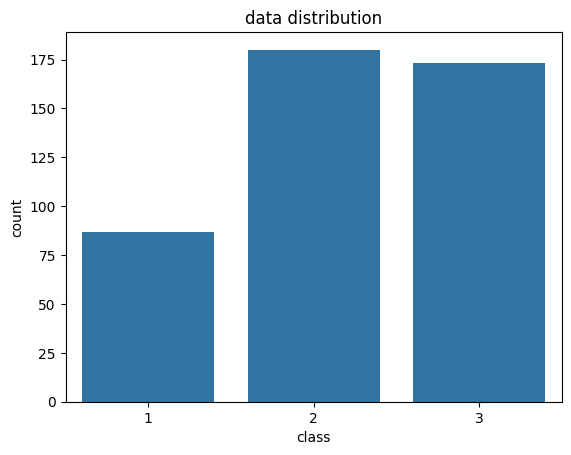

In [156]:
sns.countplot(data = df, x = 'class')
plt.title("data distribution")
plt.show()

In [157]:
df.columns

Index(['Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper',
       'Delicassen', 'class'],
      dtype='object')

### Let us define our X and Y for the model and visualize the data

In [158]:
X = df[['Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper','Delicassen']].copy()
y = df[['class']].copy()

In [159]:
def scatter_visualize(viz1, viz2, y_label):
    scatter = plt.scatter(viz1, viz2, c = y_label)
    plt.legend(handles = scatter.legend_elements()[0], labels = ['Class 1', 'Class 2', 'Class 3'])
    plt.show()

#### Let us reduce the feature from 7 to 2

In [160]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 2)
print(X.shape)
visualize = pca.fit_transform(X)
print(X.shape)

(440, 7)
(440, 7)


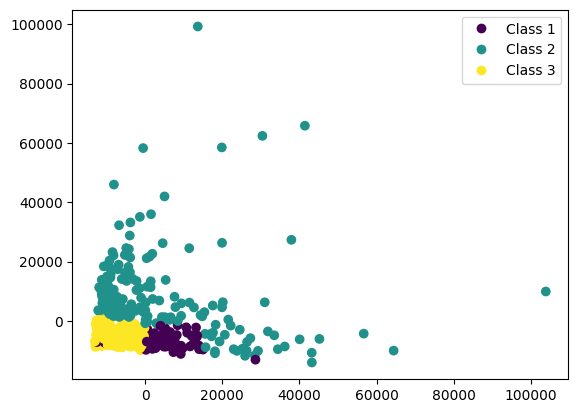

In [161]:
scatter_visualize(viz1 = visualize[:,0], viz2= visualize[:,1], y_label= y.values[:,0])

##### From scatterplot above we can see that data is multi class imblanced and non linear

### Let us use KNN algo here 

25% is test and rest 75% is broken down to train and test

In [162]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size= 0.25, random_state= 42)

#rest 75% will be split in train and Validation 
    
X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                  y_train_val, 
                                                  test_size= 0.25, 
                                                  random_state= 42)

In [163]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(247, 7) (247, 1)
(83, 7) (83, 1)
(110, 7) (110, 1)


#### Because we have multi class imbalanced data, we are using SMOTE technique

In [164]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()

X_sm, y_sm = smt.fit_resample(X_train, y_train)

In [165]:
y_sm.value_counts()

class
1        99
2        99
3        99
Name: count, dtype: int64

Anytime we use an algorithm on distance we have to make sure that features are at same scale. so we use standerization
### Standerization

In [166]:
from sklearn.preprocessing import StandardScaler

st = StandardScaler()

X_sm = st.fit_transform(X_sm.values)
X_test_scaled = st.transform(X_test.values)
X_val_scaled = st.transform(X_val.values)

y_sm = y_sm.values[:,0]
y_val = y_val.values[:,0]
y_test = y_test.values[:,0]

### KNN implementation from stractch with k = 5

taking 50th Val data as Xq 

In [167]:
X_val_scaled[50]

array([ 0.71362033, -0.59207314, -0.43731375, -0.64791553, -0.30835001,
       -0.49615976, -0.26587309])

finding distance 

In [168]:
dist = np.sqrt(np.sum((X_val_scaled[50]-X_sm)**2,axis=1) )

print(dist.shape)

(297,)


#### storing distance and Class labels togather 

In [169]:
distances = [(dist[i], y_sm[i]) for i in range (len(dist))]

#### Sorting the distance 

In [170]:
distances = sorted(distances)

#### Nearest/ First K points 

In [171]:
distances = distances[:5]

In [172]:
distances = np.array(distances)

#we are extracting the 2nd column of distance array that contains the class. We are returning the unique class label and its count
classes_count = np.unique(distances[:,1], return_counts= True)
#finds the index of the maximum value of the counts array. This index corresponds to the class that appears most frequently among the nearest neigbours 
index = classes_count[1].argmax()
#using index obtained above, this line retrives the class label that has the maximum count
pred = classes_count[0][index]

print('kNN prediction', pred)

kNN prediction 3.0


In [173]:
print('Neighbors[(distance),(Label)]:',distances)

Neighbors[(distance),(Label)]: [[0.20322766 3.        ]
 [0.21493686 3.        ]
 [0.23163983 3.        ]
 [0.28711687 3.        ]
 [0.30331238 3.        ]]


### Lets create a single function for above steps 

In [180]:
def kNN(X,Y, querypoint, k):
    #Euclidean Distance
    dist = np.sqrt(np.sum((querypoint-X)**2, axis= 1))


    #storing the distance along with labels 

    distances = [(dist[i], Y[i]) for i  in range(len(dist))]

    #sort the distance 
    distances = sorted(distances)

    #Nearest kNN points 

    distances = distances[:k]

    distances = np.array(distances)

    classes_count = np.unique(distances[:,1], return_counts= True)

    index = classes_count[1].argmax()
    pred   = classes_count[0][index]

    return int(pred), distances



In [181]:
pred,neighbors = kNN(X_sm, y_sm, X_val_scaled[50],5)

print(f'k nearest neighbors with the distance and class label :{neighbors}')

print(f'The predicted class label: {pred}')

k nearest neighbors with the distance and class label :[[0.20322766 3.        ]
 [0.21493686 3.        ]
 [0.23163983 3.        ]
 [0.28711687 3.        ]
 [0.30331238 3.        ]]
The predicted class label: 3
